# Visualizing Decisions of Convolutional Neural Networks

Convolutional Neural Networks have made a lot of progress in Computer Vision. Their accuracy is as good as humans in some tasks. However it remains hard to explain the predictions of convolutional neural networks, as they lack the interpretability offered by other models, for example decision trees.

It is often helpful to be able to explain why a model made the prediction it made. For example when a model misclassifies an image, it is hard to say why without visualizing the network's decision.

<img align="right" src="https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/example/cnn_visualization/volcano_barn_spider.png" alt="Explaining the misclassification of volcano as spider" width=500px/>

Visualizations also help build confidence about the predictions of a model. For example, even if a model correctly predicts birds as birds, we would want to confirm that the model bases its decision on the features of bird and not on the features of some other object that might occur together with birds in the dataset (like leaves).

In this tutorial, we show how to visualize the predictions made by convolutional neural networks using [Gradient-weighted Class Activation Mapping](https://arxiv.org/abs/1610.02391). Unlike many other visualization methods, Grad-CAM can be used on a wide variety of CNN model families - CNNs with fully connected layers, CNNs used for structural outputs (e.g. captioning), CNNs used in tasks with multi-model input (e.g. VQA) or reinforcement learning without architectural changes or re-training.

In the rest of this notebook, we will explain how to visualize predictions made by [VGG-16](https://arxiv.org/abs/1409.1556). We begin by importing the required dependencies. `gradcam` module contains the implementation of visualization techniques used in this notebook.

## Guided Backpropagation

![CNN Architecture](img/cnnimage.png)

#### Modified Relu for guided backpropagation
![Relu - Guided Backpropagation](img/relu_guided_backprop.png)

We start by importing the necessary dependencies.

In [1]:
from __future__ import print_function

import mxnet as mx
from mxnet import autograd, gluon, nd
from mxnet.gluon import nn

from matplotlib import pyplot as plt
import numpy as np
import cv2

import numpy
numpy.set_printoptions(threshold=numpy.nan)

%matplotlib inline

We define a custom Relu operator for guided backpropagation.

[Here](https://mxnet.incubator.apache.org/tutorials/gluon/customop.html?highlight=customop) is a tutorial on how to create custom operator in MXNet.

In [2]:
class ReluOp(mx.operator.CustomOp):
    """Modified ReLU as described in section 3.4 in https://arxiv.org/abs/1412.6806.
    This is used for guided backpropagation to get gradients of the image w.r.t activations.
    This Operator will do a regular backpropagation if `guided_backprop` is set to False
    and a guided packpropagation if `guided_backprop` is set to True. Check gradcam_demo.py
    for an example usage."""

    guided_backprop = False

    def forward(self, is_train, req, in_data, out_data, aux):
        x = in_data[0]
        y = nd.maximum(x, nd.zeros_like(x))
        self.assign(out_data[0], req[0], y)

    def backward(self, req, out_grad, in_data, out_data, in_grad, aux):
        if ReluOp.guided_backprop:
            # Get output and gradients of output
            y = out_data[0]
            dy = out_grad[0]
            # Zero out the negatives in the gradients of the output
            dy_positives = nd.maximum(dy, nd.zeros_like(dy))
            # What output values were greater than 0?
            y_ones = y.__gt__(0)
            # Mask out the values for which at least one of dy or y is negative
            dx = dy_positives * y_ones
            self.assign(in_grad[0], req[0], dx)
        else:
            # Regular backward for ReLU
            x = in_data[0]
            x_gt_zero = x.__gt__(0)
            dx = out_grad[0] * x_gt_zero
            self.assign(in_grad[0], req[0], dx)

@mx.operator.register("relu")
class ReluProp(mx.operator.CustomOpProp):
    def __init__(self):
        super(ReluProp, self).__init__(True)

    def infer_shape(self, in_shapes):
        data_shape = in_shapes[0]
        output_shape = data_shape
        return (data_shape,), (output_shape,), ()

    def create_operator(self, ctx, in_shapes, in_dtypes):
        return ReluOp()

class Activation(mx.gluon.HybridBlock):
    @staticmethod
    def set_guided_backprop(mode=False):
        ReluOp.guided_backprop = mode

    def __init__(self, act_type, **kwargs):
        assert act_type == 'relu'
        super(Activation, self).__init__(**kwargs)

    def hybrid_forward(self, F, x):
        return F.Custom(x, op_type='relu')

We define a custom Conv2D which is a wrapper around Gluon's Conv2D. The custom operator captures the output of the convolution layer and the gradient of the output.

In [3]:
class Conv2D(mx.gluon.HybridBlock):
    """Wrapper on top of gluon.nn.Conv2D to capture the output and gradients of output of a Conv2D
    layer in a network. Use `set_capture_layer_name` to select the layer
    whose outputs and gradients of outputs need to be captured. After the backward pass,
    `conv_output` will contain the output and `conv_output.grad` will contain the
    output's gradients. Check gradcam_demo.py for example usage."""

    conv_output = None
    capture_layer_name = None

    def __init__(self, channels, kernel_size, strides=(1, 1), padding=(0, 0),
                 dilation=(1, 1), groups=1, layout='NCHW',
                 activation=None, use_bias=True, weight_initializer=None,
                 bias_initializer='zeros', in_channels=0, **kwargs):
        super(Conv2D, self).__init__(**kwargs)
        self.conv = nn.Conv2D(channels, kernel_size, strides=strides, padding=padding,
                             dilation=dilation, groups=groups, layout=layout,
                             activation=activation, use_bias=use_bias, weight_initializer=weight_initializer,
                             bias_initializer=bias_initializer, in_channels=in_channels)

    def hybrid_forward(self, F, x):
        out = self.conv(x)
        name = self._prefix[:-1]
        if name == Conv2D.capture_layer_name:
            out.attach_grad()
            Conv2D.conv_output = out
        return out

We build a VGG 16 network that we'll use for visualization.
This code was borrowed from model zoo. Only difference is - it uses custom Conv2D and Activation (Relu) instead of the Gluon operators.

In [4]:
import os
from mxnet.gluon.model_zoo import model_store

from mxnet.initializer import Xavier
from mxnet.gluon.nn import MaxPool2D, Flatten, Dense, Dropout, BatchNorm

class VGG(mx.gluon.HybridBlock):
    def __init__(self, layers, filters, classes=1000, **kwargs):
        super(VGG, self).__init__(**kwargs)
        assert len(layers) == len(filters)
        with self.name_scope():
            self.features = self._make_features(layers, filters)
            self.features.add(Dense(4096, activation='relu',
                                       weight_initializer='normal',
                                       bias_initializer='zeros'))
            self.features.add(Dropout(rate=0.5))
            self.features.add(Dense(4096, activation='relu',
                                       weight_initializer='normal',
                                       bias_initializer='zeros'))
            self.features.add(Dropout(rate=0.5))
            self.output = Dense(classes,
                                   weight_initializer='normal',
                                   bias_initializer='zeros')

    def _make_features(self, layers, filters):
        featurizer = mx.gluon.nn.HybridSequential(prefix='')
        for i, num in enumerate(layers):
            for _ in range(num):
                featurizer.add(Conv2D(filters[i], kernel_size=3, padding=1,
                                         weight_initializer=Xavier(rnd_type='gaussian',
                                                                   factor_type='out',
                                                                   magnitude=2),
                                         bias_initializer='zeros'))
                featurizer.add(Activation('relu'))
            featurizer.add(MaxPool2D(strides=2))
        return featurizer

    def hybrid_forward(self, F, x):
        x = self.features(x)
        x = self.output(x)
        return x

# Number of convolution layers and number of filters for each VGG configuration.
# Check the VGG [paper](https://arxiv.org/abs/1409.1556) for more details on the different architectures.
vgg_spec = {11: ([1, 1, 2, 2, 2], [64, 128, 256, 512, 512]),
            13: ([2, 2, 2, 2, 2], [64, 128, 256, 512, 512]),
            16: ([2, 2, 3, 3, 3], [64, 128, 256, 512, 512]),
            19: ([2, 2, 4, 4, 4], [64, 128, 256, 512, 512])}

def get_vgg(num_layers, ctx=mx.cpu(), root=os.path.join('~', '.mxnet', 'models'), **kwargs):

    # Get the number of convolution layers and filters
    layers, filters = vgg_spec[num_layers]

    # Build the VGG network
    net = VGG(layers, filters, **kwargs)

    # Load pretrained weights from model zoo
    from mxnet.gluon.model_zoo.model_store import get_model_file
    net.load_params(get_model_file('vgg%d' % num_layers, root=root), ctx=ctx)

    return net

def vgg16(**kwargs):
    return get_vgg(16, **kwargs)

network = vgg16(ctx=mx.cpu())

Let's pick an image we'll use for vizualization

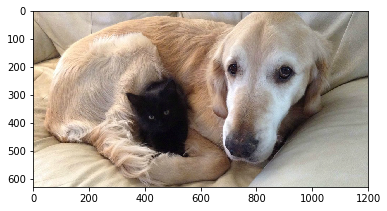

In [5]:
img_path = "dog-cat.png"
img = mx.image.imread(img_path)
plt.imshow(img.asnumpy())

We need to pre-process the image before we can feed it to the network.

In [6]:
image_sz = (224, 224)

def preprocess(data):
    data = mx.image.imresize(data, image_sz[0], image_sz[1])
    data = data.astype(np.float32)
    data = data/255
    data = mx.image.color_normalize(data,
                                    mean=mx.nd.array([0.485, 0.456, 0.406]),
                                    std=mx.nd.array([0.229, 0.224, 0.225]))
    data = mx.nd.transpose(data, (2,0,1))
    return data

orig_img = mx.img.imread(img_path)
prep_img = preprocess(orig_img)
prep_img = prep_img.expand_dims(axis=0)

Treat image as a parameter by attaching gradient. Compute gradients for the image.

This shows which parts of the image most activates the output neuron.

In [7]:
def get_image_grad(net, image, class_id=None):
    image.attach_grad()
    Conv2D.capture_layer_name = None
    Activation.set_guided_backprop(True)
    
    with autograd.record(train_mode=False):
        out = net(image)
    
    if class_id == None:
        model_output = out.asnumpy()
        class_id = np.argmax(model_output)
    
    one_hot_target = mx.nd.one_hot(mx.nd.array([class_id]), 1000)
    out.backward(one_hot_target, train_mode=False)
    
    return image.grad[0].asnumpy()

Compute the gradient of the image.

In [8]:
imggrad = get_image_grad(network, prep_img)

Display the gradients as an image

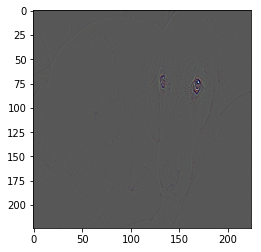

In [25]:
def grad_to_image(gradient):
    """Convert gradients of image obtained using `get_image_grad`
    into image. This shows parts of the image that is most strongly activating
    the output neurons."""
    # Normalize to values between 0 and 1
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Normalize to values between 0 and 255
    gradient = np.uint8(gradient * 255).transpose(1, 2, 0)
    # gradient = gradient[..., ::-1]
    return gradient

plt.imshow(grad_to_image(imggrad))

## Computing CAM (Class Activation Mapping)

![CNN Architecture](img/cnnimage.png)

`get_conv_out_grad` does forward and backward pass using the given image and records the output of a given convolution layer and its gradients.

In [10]:
def get_conv_out_grad(net, prep_img, class_id=None, conv_layer_name=None):
    
    Conv2D.capture_layer_name = conv_layer_name
    Activation.set_guided_backprop(False)
    
    with autograd.record(train_mode=False):
        out = net(prep_img)
    
    if class_id == None:
        model_output = out.asnumpy()
        class_id = np.argmax(model_output)
    
    one_hot_target = mx.nd.one_hot(mx.nd.array([class_id]), 1000)
    out.backward(one_hot_target, train_mode=False)
    
    conv_out = Conv2D.conv_output
    return conv_out[0].asnumpy(), conv_out.grad[0].asnumpy()

In [11]:
network.features

HybridSequential(
  (0): Conv2D(
    (conv): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (1): Activation(
  
  )
  (2): Conv2D(
    (conv): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (3): Activation(
  
  )
  (4): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (5): Conv2D(
    (conv): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (6): Activation(
  
  )
  (7): Conv2D(
    (conv): Conv2D(128 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (8): Activation(
  
  )
  (9): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (10): Conv2D(
    (conv): Conv2D(128 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (11): Activation(
  
  )
  (12): Conv2D(
    (conv): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (13): Activation(
  
  )
  (14): Conv2D(
    (conv): Conv2D(256 -> 256, kernel_size=(3, 3),

In [12]:
last_conv_layer_name = network.features[28]._name
conv_out, conv_grad = get_conv_out_grad(network, prep_img, conv_layer_name=last_conv_layer_name)

In [13]:
conv_grad.shape

(512, 14, 14)

In [14]:
# weights captures the importance of each feature map
weights = np.mean(conv_grad, axis=(1, 2))

# Multiply each feature map with its importance and add them all
cam = np.ones(conv_grad.shape[1:], dtype=np.float32)
for i, w in enumerate(weights):
    cam += w * conv_out[i, :, :]

Visualize the CAM (Class Activation Map)

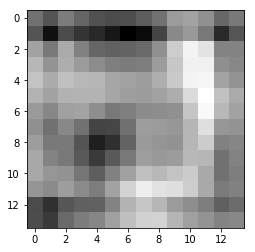

In [15]:
plt.imshow(cam, cmap='gray')

Resize CAM to the size of the image

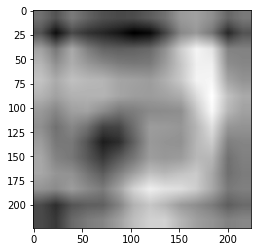

In [16]:
cam = cv2.resize(cam, (224, 224))
cam = np.maximum(cam, 0)
# Convert to 0 to 1 range
cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
# Convert to 0 to 255 range
cam = np.uint8(cam * 255)
plt.imshow(cam, cmap='gray')

Convert to heatmap

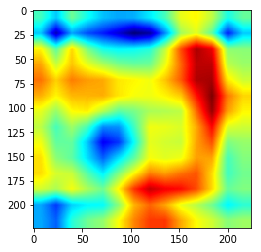

In [17]:
cam_threshold = (cam > 0) * cam
#plt.imshow(c, cmap='gray')

heatmap = cv2.applyColorMap(cam_threshold, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
plt.imshow(heatmap)

Render heatmap on original image

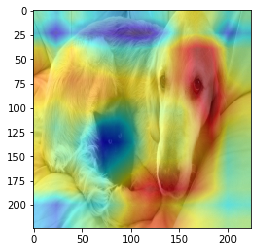

In [19]:
img_resized = cv2.resize(img.asnumpy(), (224,224), interpolation = cv2.INTER_AREA)
heatmap_on_img = cv2.addWeighted(heatmap, 0.5, img_resized, 0.5, 0)
plt.imshow(heatmap_on_img)

## Combine CAM and Guided Gradients to create Guided Grad-CAM

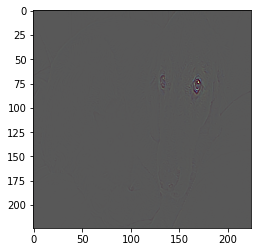

In [20]:
ggcam  = np.multiply(cam, imggrad)
plt.imshow(grad_to_image(ggcam))

## Convert to grayscale

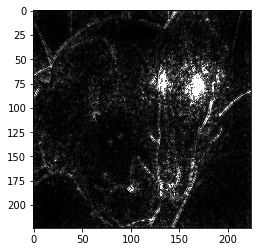

In [21]:
def to_grayscale(cv2im):
    """Convert gradients to grayscale. This gives a saliency map."""
    # How strongly does each position activate the output
    grayscale_im = np.sum(np.abs(cv2im), axis=0)

    # Normalize between min and 99th percentile
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1)

    return grayscale_im

ggcam_gray = to_grayscale(ggcam)
plt.imshow(ggcam_gray, cmap='gray')